<!--NOTEBOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="./figures/LogoOpenclassrooms.png">
<font size="4">
<p>
Cette étude a été réalisée dans le cadre du 6ème projet de ma formation Datascientist dispensée en MOOC par 
</p>    
<font color='blus'>Openclassrooms / écoles Centrale-Supélec</font>.
<p>
Le modèle étudié se base sur les données fournies par le site de StackOverFlow.
</p>
<p>
La requête SQL suivante a permis de récupérer :

* les données du jeux d'entrainement:     

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id<200000 and PostTypeId=1;``
    

* les données du jeux de test :

    ``SELECT Id, PostTypeId, Body, Title, Tags from Posts where Id>=200000 and Id<300000 and PostTypeId=1;``
    
</p>
<p>



# <font color='blus'>1. Paramaters</font>

In [1]:
#-------------------------------------------------------------------------------
# Apply or not stemming process over sentences
#-------------------------------------------------------------------------------
is_stemming=False

# <font color='blus'>2. Data acquisition</font>

In [2]:
import pandas as pd
file_name="./data/train_StackOverFlow_BodyTitleTags.csv"
df_sof_train=pd.read_csv(file_name)

In [3]:
print(df_sof_train.columns)

Index(['Id', 'PostTypeId', 'Body', 'Title', 'Tags'], dtype='object')


# <font color='blus'>3. Data-set processing</font>

**Merge Body and Title columns**

``Title`` elements are regarded as synthetisis of ``Body`` elements.

Merging ``Title`` with ``Body`` enreach ``Body`` contents with more relevant informations.

In [4]:
df_sof_train['Body']=df_sof_train['Body']+df_sof_train['Title']

**Dataset preprocessing**

Expressions between markers ``code`` and ``/code`` are all removed.

Such expressions are computer language specifics, different as english language. It is considered as having  no semantic value for english language.

In [9]:
import p6_util
df_sof_train = p6_util.p6_df_standardization(df_sof_train)


Cleaning text in-between markers <code></code> markers...

Cleaning LXML markers...

Remove verbs from sentences...

Filtering alpha-numeroc words from sentences...

Removing stopwords...

Lemmatization ...


**Save cleaned train-dataset**

In [10]:
import p5_util
file_name='./data/df_sof_train.dump'
p5_util.object_dump(df_sof_train, file_name)

# <font color='blus'>4. Data analysis</font>

**Cleaned dataset is loaded from dumped file**

In [11]:
import p5_util
file_name='./data/df_sof_train.dump'
df_sof_train = p5_util.object_load(file_name)

p5_util.object_load : fileName= ./data/df_sof_train.dump


## 4.1 Words frequencies computation

Series ``df_sof_train.Body`` is converted into a dictionary in order to feed ``compute_frequency_sentence`` function.

In [12]:
import p6_util
dict_body_train = df_sof_train.Body.to_dict()
freq_body_train = p6_util.compute_frequency_sentence(dict_body_train, token_mode='nltk')

<Figure size 720x720 with 0 Axes>

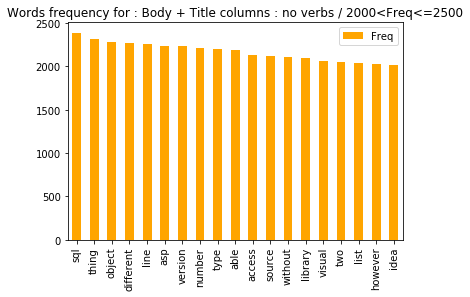

In [14]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2000<Freq<=2500")

<Figure size 720x720 with 0 Axes>

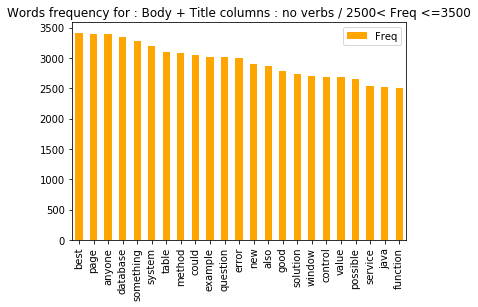

In [15]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="2500< Freq <=3500")

<Figure size 720x720 with 0 Axes>

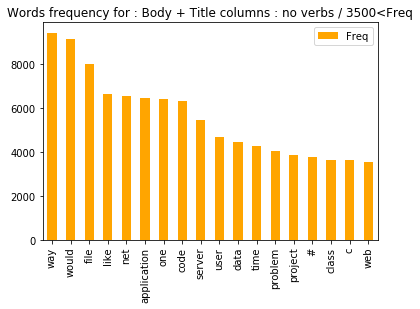

In [16]:
import p6_util_plot
p6_util_plot.dict_plot_frequency(freq_body_train, "Body + Title columns : no verbs", query="3500<Freq")

**Convert ``FreqDist`` as a ``DataFrame`` object and filter frequencies values.**

In [17]:
import p6_util
df_freq_train = p6_util.get_df_from_FreqDist(freq_body_train, query="500<Freq")

df_freq_train.shape

(317, 1)